In [ ]:
%matplotlib inline
!pip install shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
import time
import shap

from scipy.stats import zscore, boxcox, normaltest,pearsonr
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, StratifiedKFold, cross_val_score,KFold
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error, explained_variance_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, auc, roc_curve

import xgboost as xgb
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('/content/Imputed_and_cleaned_data.csv', low_memory=False)

df['Quarter'] = df['Quarter'].fillna(0)

print(df[['Year', 'Quarter']].head(10))

df.to_csv('/content/Imputed_and_cleaned_data_with_filled_quarter.csv', index=False)

print("Replaced NaN with 0 in 'Quarter' column and saved new file.")

   Year Quarter
0  2021      Q1
1  2021      Q1
2  2021      Q1
3  2021      Q1
4  2021      Q1
5  2021      Q1
6  2021      Q1
7  2021      Q1
8  2021      Q1
9  2021      Q1
Replaced NaN with 0 in 'Quarter' column and saved new file.


Shape of the dataset: (874836, 9)

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874836 entries, 0 to 874835
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Country Name        874836 non-null  object 
 1   Country Code        874836 non-null  object 
 2   Series Name         874836 non-null  object 
 3   Series Code         874836 non-null  object 
 4   Quarter             874836 non-null  object 
 5   Value               827640 non-null  float64
 6   Year                874836 non-null  int64  
 7   Source              874836 non-null  object 
 8   Indicator Category  874836 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 60.1+ MB

Missing Value Percentages:
Country Name          0.00000
Country Code          0.00000
Series Name           0.00000
Series Code           0.00000
Quarter               0.00000
Value                 5.39484
Year                  

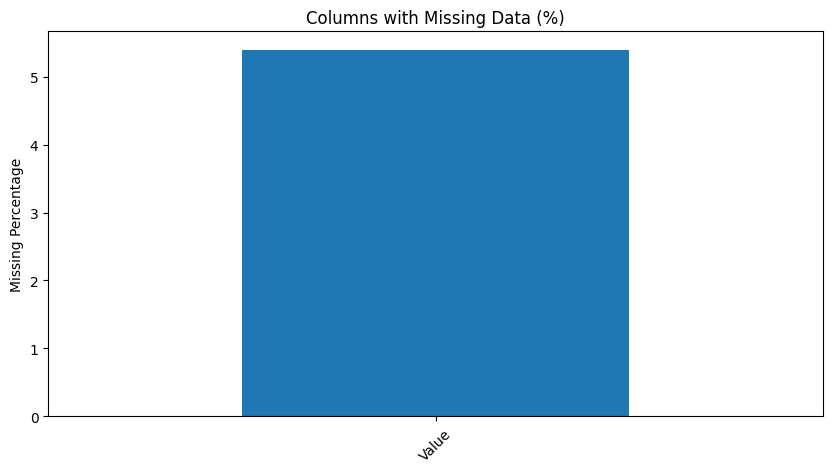

In [ ]:
df = pd.read_csv('/content/Imputed_and_cleaned_data_with_filled_quarter.csv')

print("Shape of the dataset:", df.shape)
print("\nBasic Info:")
df.info()

# Missing Values
print("\nMissing Value Percentages:")
print(df.isnull().mean() * 100)

# Quick Look at Indicator Categories
print("\nIndicator Category Distribution:")
print(df['Indicator Category'].value_counts())

# Plot missing values
missing_percent = df.isnull().mean() * 100
plt.figure(figsize=(10, 5))
missing_percent[missing_percent > 0].sort_values(ascending=False).plot(kind='bar')
plt.title('Columns with Missing Data (%)')
plt.ylabel('Missing Percentage')
plt.xticks(rotation=45)
plt.show()

In [ ]:
eda_df = pd.read_csv('/content/Imputed_and_cleaned_data_with_filled_quarter.csv')
descriptive_stats_all = eda_df.describe(include='all')
print(descriptive_stats_all)
eda_df.dtypes

       Country Name Country Code  \
count        874836       874836   
unique           76           76   
top         Albania          ALB   
freq          11511        11511   
mean            NaN          NaN   
std             NaN          NaN   
min             NaN          NaN   
25%             NaN          NaN   
50%             NaN          NaN   
75%             NaN          NaN   
max             NaN          NaN   

                                              Series Name  \
count                                              874836   
unique                                               2145   
top     Gross PSD, Nonfinancial Public Corp., Short-te...   
freq                                                  912   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%               

,0
Country Name,object
Country Code,object
Series Name,object
Series Code,object
Quarter,object
Value,float64
Year,int64
Source,object
Indicator Category,object


In [ ]:
df = pd.read_csv('/content/Imputed_and_cleaned_data_with_filled_quarter.csv', low_memory=False)

region_mapping = {
    # North America
    'United States': 'North America', 'Canada': 'North America', 'Mexico': 'North America',

    # Europe
    'Germany': 'Europe', 'France': 'Europe', 'United Kingdom': 'Europe',
    'Italy': 'Europe', 'Spain': 'Europe', 'Poland': 'Europe',
    'Netherlands': 'Europe', 'Belgium': 'Europe', 'Austria': 'Europe',
    'Denmark': 'Europe', 'Finland': 'Europe', 'Sweden': 'Europe',
    'Norway': 'Europe', 'Ireland': 'Europe', 'Switzerland': 'Europe',
    'Greece': 'Europe', 'Portugal': 'Europe', 'Czechia': 'Europe',
    'Hungary': 'Europe', 'Bulgaria': 'Europe', 'Croatia': 'Europe',
    'Lithuania': 'Europe', 'Latvia': 'Europe', 'Estonia': 'Europe',
    'Romania': 'Europe', 'Slovakia': 'Europe', 'Slovenia': 'Europe',
    'Luxembourg': 'Europe', 'Malta': 'Europe', 'Cyprus': 'Europe',
    'Iceland': 'Europe',
    # Added countries with all possible name variations
    'Albania': 'Europe',
    'Armenia': 'Europe',
    'Bosnia and Herzegovina': 'Europe',
    'Georgia': 'Europe',
    'Kosovo': 'Europe',
    'Moldova': 'Europe',
    'North Macedonia': 'Europe',
    'Slovak Republic': 'Europe',
    'Turkiye': 'Europe',
    'Türkiye': 'Europe',
    ' Turkiye': 'Europe',  # Note the space before Turkiye
    'Turkey': 'Europe',

    # East Asia & Pacific
    'China': 'East Asia & Pacific', 'Japan': 'East Asia & Pacific',
    'South Korea': 'East Asia & Pacific', 'Australia': 'East Asia & Pacific',
    'New Zealand': 'East Asia & Pacific', 'Indonesia': 'East Asia & Pacific',
    'Malaysia': 'East Asia & Pacific', 'Thailand': 'East Asia & Pacific',
    'Philippines': 'East Asia & Pacific', 'Vietnam': 'East Asia & Pacific',
    'Cambodia': 'East Asia & Pacific', 'Fiji': 'East Asia & Pacific',
    'Mongolia': 'East Asia & Pacific', 'Korea, Rep.': 'East Asia & Pacific',

    # South Asia
    'India': 'South Asia', 'Pakistan': 'South Asia', 'Bangladesh': 'South Asia',
    'Sri Lanka': 'South Asia', 'Nepal': 'South Asia', 'Bhutan': 'South Asia',
    'Afghanistan': 'South Asia', 'Maldives': 'South Asia',

    # Central Asia
    'Kazakhstan': 'Central Asia',
    'Kyrgyz Republic': 'Central Asia',
    'Tajikistan': 'Central Asia',

    # Latin America & Caribbean
    'Brazil': 'Latin America & Caribbean', 'Argentina': 'Latin America & Caribbean',
    'Colombia': 'Latin America & Caribbean', 'Chile': 'Latin America & Caribbean',
    'Peru': 'Latin America & Caribbean', 'Venezuela': 'Latin America & Caribbean',
    'Ecuador': 'Latin America & Caribbean', 'Bolivia': 'Latin America & Caribbean',
    'Paraguay': 'Latin America & Caribbean', 'Uruguay': 'Latin America & Caribbean',
    'Costa Rica': 'Latin America & Caribbean', 'Panama': 'Latin America & Caribbean',
    'Dominican Republic': 'Latin America & Caribbean', 'Guatemala': 'Latin America & Caribbean',
    'Honduras': 'Latin America & Caribbean', 'El Salvador': 'Latin America & Caribbean',
    'Nicaragua': 'Latin America & Caribbean', 'Jamaica': 'Latin America & Caribbean',
    'Haiti': 'Latin America & Caribbean', 'Barbados': 'Latin America & Caribbean',
    'Suriname': 'Latin America & Caribbean', 'St. Lucia': 'Latin America & Caribbean',

    # Middle East & North Africa
    'Saudi Arabia': 'Middle East & North Africa', 'United Arab Emirates': 'Middle East & North Africa',
    'Qatar': 'Middle East & North Africa', 'Kuwait': 'Middle East & North Africa',
    'Oman': 'Middle East & North Africa', 'Israel': 'Middle East & North Africa',
    'Morocco': 'Middle East & North Africa', 'Tunisia': 'Middle East & North Africa',
    'Egypt': 'Middle East & North Africa', 'Lebanon': 'Middle East & North Africa',
    'Jordan': 'Middle East & North Africa', 'Algeria': 'Middle East & North Africa',
    'Iran': 'Middle East & North Africa', 'Iraq': 'Middle East & North Africa',
    'Yemen': 'Middle East & North Africa', 'Bahrain': 'Middle East & North Africa',

    # Sub-Saharan Africa
    'South Africa': 'Sub-Saharan Africa', 'Nigeria': 'Sub-Saharan Africa',
    'Kenya': 'Sub-Saharan Africa', 'Ghana': 'Sub-Saharan Africa',
    'Ethiopia': 'Sub-Saharan Africa', 'Angola': 'Sub-Saharan Africa',
    'Tanzania': 'Sub-Saharan Africa', 'Uganda': 'Sub-Saharan Africa',
    'Botswana': 'Sub-Saharan Africa', 'Mauritius': 'Sub-Saharan Africa',
    'Cote d\'Ivoire': 'Sub-Saharan Africa', 'Lesotho': 'Sub-Saharan Africa',
    'Madagascar': 'Sub-Saharan Africa', 'Burkina Faso': 'Sub-Saharan Africa',
    'Rwanda': 'Sub-Saharan Africa',
    'Senegal': 'Sub-Saharan Africa'
}

# Map countries to regions
df['Region'] = df['Country Name'].map(region_mapping)

# Basic mapping check
mapped_countries = df['Country Name'][df['Region'].notna()].nunique()
total_countries = df['Country Name'].nunique()
print(f"\nSuccessfully mapped {mapped_countries} out of {total_countries} countries to regions ({mapped_countries/total_countries*100:.1f}%)")

# Show unmapped countries
unmapped_countries = df[df['Region'].isna()]['Country Name'].unique()

if len(unmapped_countries) > 0:
    print(f"\nUnmapped countries ({len(unmapped_countries)} countries):")
    for country in sorted(unmapped_countries):
        print(f"- {country}")
else:
    print("\nAll countries successfully mapped!")

df.to_csv('/content/Imputed_and_cleaned_data_with_region.csv', index=False)
print("\nSaved updated dataset with Region column: /content/Imputed_and_cleaned_data_with_region.csv")



Successfully mapped 76 out of 76 countries to regions (100.0%)

All countries successfully mapped!

Saved updated dataset with Region column: /content/Imputed_and_cleaned_data_with_region.csv


In [ ]:
file_path = '/content/Imputed_and_cleaned_data_with_region.csv'
df = pd.read_csv(file_path, low_memory=False)

positive_mask = df['Value'] > 0
non_positive_mask = ~positive_mask

transformed_values = np.empty(len(df))
transformed_values.fill(np.nan)

# Box-Cox transformation to positive values
if positive_mask.sum() > 0:
    positive_values = df.loc[positive_mask, 'Value'].values
    transformed_values[positive_mask] = boxcox(positive_values)[0]

# Yeo-Johnson transformation to zero or negative values
if non_positive_mask.sum() > 0:
    pt = PowerTransformer(method='yeo-johnson')
    non_positive_values = df.loc[non_positive_mask, 'Value'].values.reshape(-1, 1)
    transformed_values[non_positive_mask] = pt.fit_transform(non_positive_values).flatten()


df['Value_Transformed'] = transformed_values

null_count = np.isnan(transformed_values).sum()

transformed_summary = {
    "Total Rows": len(df),
    "Box-Cox Applied (positive values)": int(positive_mask.sum()),
    "Yeo-Johnson Applied (zero or negative values)": int(non_positive_mask.sum()),
    "Nulls in Value_Transformed (if any)": int(null_count)
}

output_path = '/content/Transformed_Imputed_and_cleaned_data_with_region.csv'
df.to_csv(output_path, index=False)
print(transformed_summary)

{'Total Rows': 874836, 'Box-Cox Applied (positive values)': 766347, 'Yeo-Johnson Applied (zero or negative values)': 108489, 'Nulls in Value_Transformed (if any)': 47196}


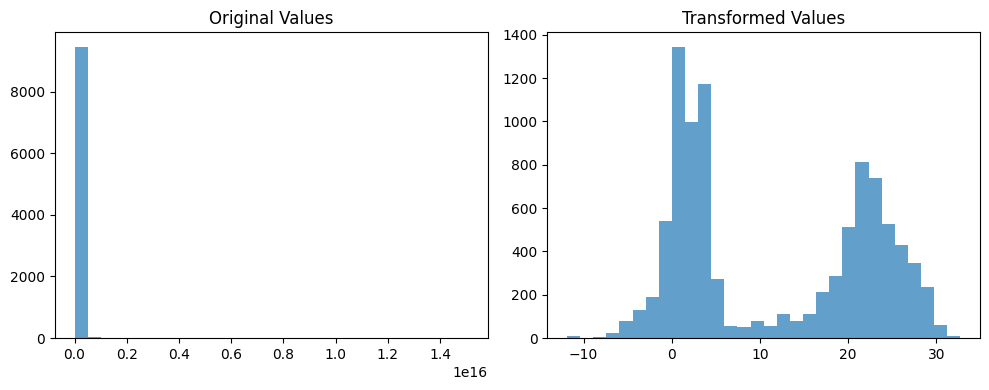

Sample size: 10000 records

Skewness (closer to 0 = more normal):
  Original: 36.3090
  Transformed: 0.1744
  Improvement: 36.1346 (improved)

Kurtosis (closer to 0 = more normal):
  Original: 1526.6207
  Transformed: -1.6260
  Improvement: 1524.9947 (improved)

D'Agostino-Pearson Test (p > 0.05 suggests normality):
  Original: p=0.00000000
  Transformed: p=0.00000000
SUCCESSFUL TRANSFORMATION: The data appears more normally distributed after transformation.


In [ ]:
file_path = '/content/Imputed_and_cleaned_data_with_region.csv'
df = pd.read_csv(file_path, low_memory=False)

positive_mask = df['Value'] > 0
non_positive_mask = ~positive_mask

transformed_values = np.empty(len(df))
transformed_values.fill(np.nan)

# Box-Cox transformation to positive values
if positive_mask.sum() > 0:
    positive_values = df.loc[positive_mask, 'Value'].values
    transformed_values[positive_mask] = boxcox(positive_values)[0]

# Yeo-Johnson transformation to zero or negative values
if non_positive_mask.sum() > 0:
    pt = PowerTransformer(method='yeo-johnson')
    non_positive_values = df.loc[non_positive_mask, 'Value'].values.reshape(-1, 1)
    transformed_values[non_positive_mask] = pt.fit_transform(non_positive_values).flatten()

df['Value_Transformed'] = transformed_values

# NORMALITY CHECKS:

# Sample data
sample_size = min(10000, len(df))
random_indexes = random.sample(range(len(df)), sample_size)
sample_df = df.iloc[random_indexes]

original_skew = sample_df['Value'].skew()
original_kurt = sample_df['Value'].kurtosis()
transformed_skew = sample_df['Value_Transformed'].skew()
transformed_kurt = sample_df['Value_Transformed'].kurtosis()

# D'Agostino's K^2 Test
# Null hypothesis: data comes from a normal distribution
original_k2, original_p = normaltest(sample_df['Value'].dropna())
transformed_k2, transformed_p = normaltest(sample_df['Value_Transformed'].dropna())

skew_improvement = abs((abs(transformed_skew) - abs(original_skew)) / abs(original_skew) * 100) if original_skew != 0 else np.inf
kurt_improvement = abs((abs(transformed_kurt) - abs(original_kurt)) / abs(original_kurt) * 100) if original_kurt != 0 else np.inf

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(sample_df['Value'].dropna(), bins=30, alpha=0.7)
plt.title('Original Values')

plt.subplot(1, 2, 2)
plt.hist(sample_df['Value_Transformed'].dropna(), bins=30, alpha=0.7)
plt.title('Transformed Values')
plt.tight_layout()
plt.show()

print(f"Sample size: {sample_size} records")

print("\nSkewness (closer to 0 = more normal):")
print(f"  Original: {original_skew:.4f}")
print(f"  Transformed: {transformed_skew:.4f}")
print(f"  Improvement: {abs(original_skew) - abs(transformed_skew):.4f} ({'improved' if abs(transformed_skew) < abs(original_skew) else 'worsened'})")

print("\nKurtosis (closer to 0 = more normal):")
print(f"  Original: {original_kurt:.4f}")
print(f"  Transformed: {transformed_kurt:.4f}")
print(f"  Improvement: {abs(original_kurt) - abs(transformed_kurt):.4f} ({'improved' if abs(transformed_kurt) < abs(original_kurt) else 'worsened'})")

print("\nD'Agostino-Pearson Test (p > 0.05 suggests normality):")
print(f"  Original: p={original_p:.8f}")
print(f"  Transformed: p={transformed_p:.8f}")

# Overall assessment
is_skew_better = abs(transformed_skew) < abs(original_skew)
is_kurt_better = abs(transformed_kurt) < abs(original_kurt)
is_p_better = transformed_p > original_p

total_improvements = sum([is_skew_better, is_kurt_better, is_p_better])

if total_improvements >= 2:
    print("SUCCESSFUL TRANSFORMATION: The data appears more normally distributed after transformation.")
elif total_improvements == 1:
    print("PARTIAL IMPROVEMENT: The transformation improved some aspects of normality but not others.")
else:
    print("UNSUCCESSFUL TRANSFORMATION: The transformation did not improve normality.")

output_path = '/content/Transformed_Imputed_and_cleaned_data_with_region.csv'
df.to_csv(output_path, index=False)

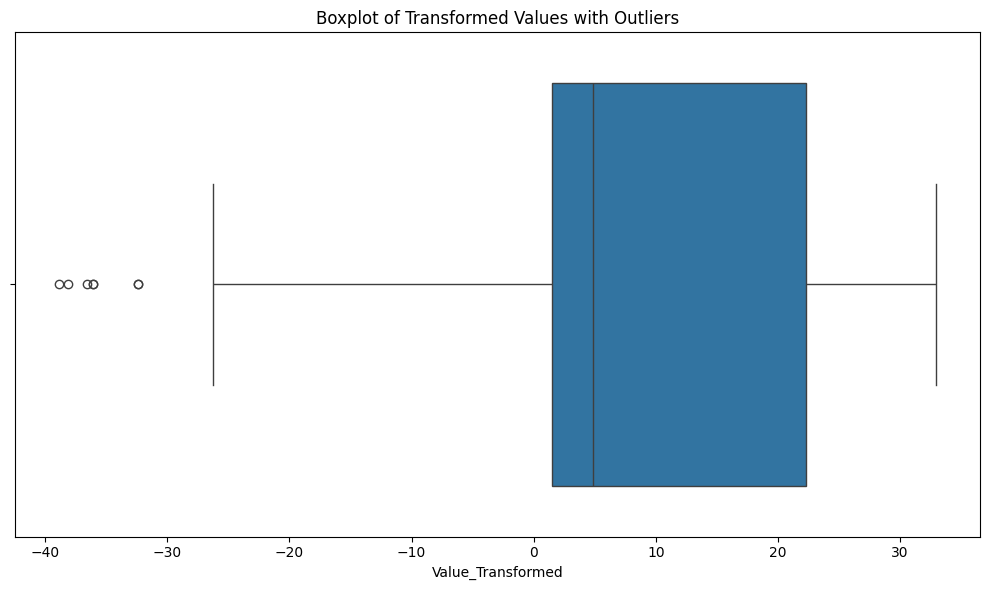

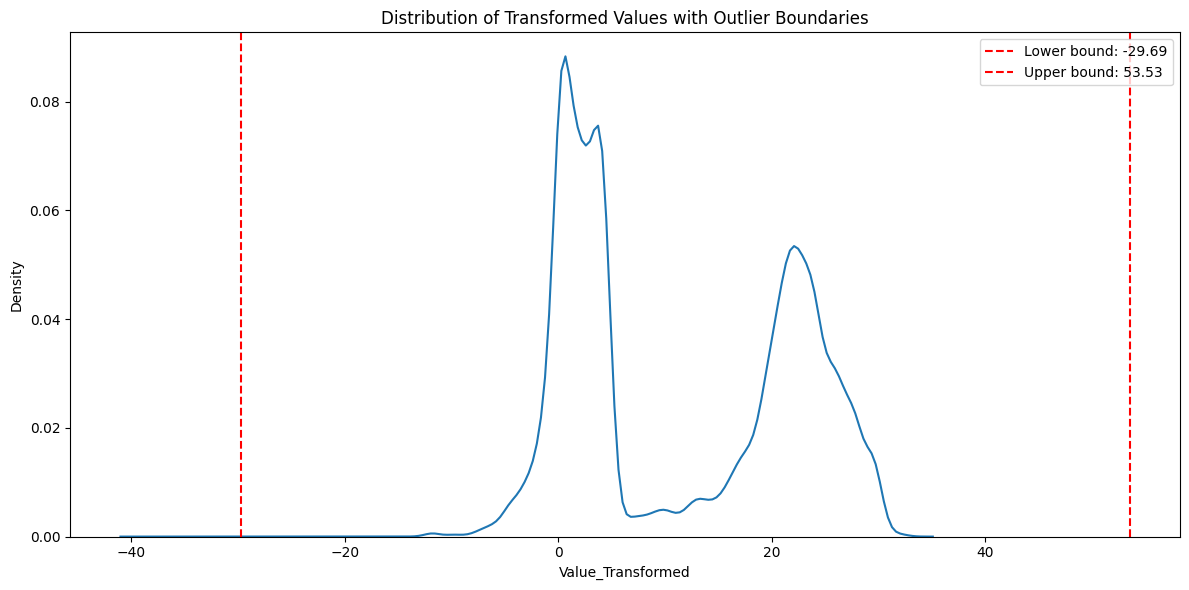

Q1 (25th percentile): 1.5156
Q3 (75th percentile): 22.3207
IQR: 20.8050
Lower bound (Q1 - 1.5*IQR): -29.6919
Upper bound (Q3 + 1.5*IQR): 53.5282
Number of outliers: 7 out of 827640 values (0.00%)

Outlier Sample (first 10):
[-32.41261685 -32.41261685 -36.56604797 -38.10452043 -38.88815915
 -36.12058094 -36.11313169]

Outliers by Region:
Region
Latin America & Caribbean    3
Europe                       2
East Asia & Pacific          1
Central Asia                 1
Name: count, dtype: int64

Percentage of Outliers by Region:
Region
Central Asia                 0.002896
Latin America & Caribbean    0.002005
East Asia & Pacific          0.001241
Europe                       0.000446
North America                     NaN
South Asia                        NaN
Sub-Saharan Africa                NaN
Name: count, dtype: float64


In [ ]:
file_path = '/content/Transformed_Imputed_and_cleaned_data_with_region.csv'
df = pd.read_csv(file_path, low_memory=False)

transformed_data = df['Value_Transformed'].dropna()

Q1 = transformed_data.quantile(0.25)
Q3 = transformed_data.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = transformed_data[(transformed_data < lower_bound) | (transformed_data > upper_bound)]
outlier_percentage = len(outliers) / len(transformed_data) * 100

# boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=transformed_data)
plt.title('Boxplot of Transformed Values with Outliers')
plt.tight_layout()
plt.show()

# KDE plot with outlier boundaries marked
plt.figure(figsize=(12, 6))
sns.kdeplot(transformed_data)
plt.axvline(x=lower_bound, color='r', linestyle='--', label=f'Lower bound: {lower_bound:.2f}')
plt.axvline(x=upper_bound, color='r', linestyle='--', label=f'Upper bound: {upper_bound:.2f}')
plt.title('Distribution of Transformed Values with Outlier Boundaries')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Q1 (25th percentile): {Q1:.4f}")
print(f"Q3 (75th percentile): {Q3:.4f}")
print(f"IQR: {IQR:.4f}")
print(f"Lower bound (Q1 - 1.5*IQR): {lower_bound:.4f}")
print(f"Upper bound (Q3 + 1.5*IQR): {upper_bound:.4f}")
print(f"Number of outliers: {len(outliers)} out of {len(transformed_data)} values ({outlier_percentage:.2f}%)")

if len(outliers) > 0:
    print("\nOutlier Sample (first 10):")
    print(outliers.head(10).values)

    df['Is_Outlier'] = df['Value_Transformed'].apply(
        lambda x: True if (not pd.isna(x) and (x < lower_bound or x > upper_bound)) else False
    )

    if 'Region' in df.columns:
        outliers_by_region = df[df['Is_Outlier']]['Region'].value_counts()
        print("\nOutliers by Region:")
        print(outliers_by_region)

        region_counts = df['Region'].value_counts()
        outlier_percentages = (outliers_by_region / region_counts * 100).sort_values(ascending=False)
        print("\nPercentage of Outliers by Region:")
        print(outlier_percentages)

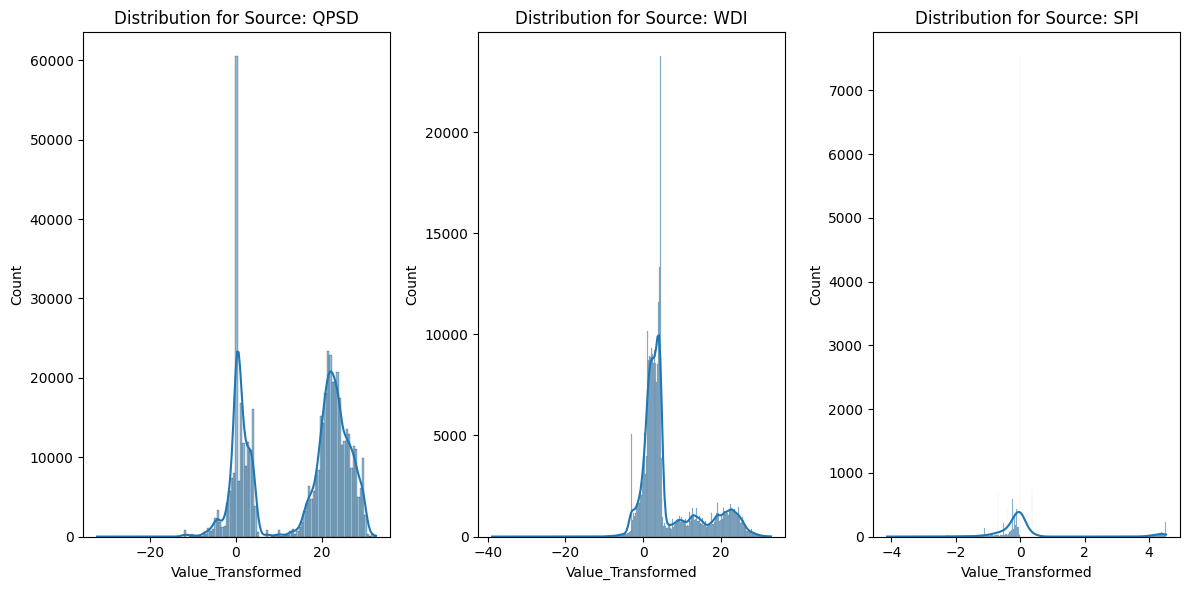

Statistics by data source:
             mean     median        std      skew   count
Source                                                   
QPSD    14.823796  20.295442  11.221044 -0.409786  514368
SPI      0.192759   0.000000   1.303037  2.514035   16416
WDI      6.532919   3.651460   7.831394  1.251596  296856


In [ ]:
file_path = '/content/Transformed_Imputed_and_cleaned_data_with_region.csv'
df = pd.read_csv(file_path, low_memory=False)
plt.figure(figsize=(12, 6))
for i, source in enumerate(df['Source'].unique()):
    plt.subplot(1, len(df['Source'].unique()), i + 1)
    source_data = df[df['Source'] == source]['Value_Transformed'].dropna()
    sns.histplot(source_data, kde=True)
    plt.title(f'Distribution for Source: {source}')
plt.tight_layout()
plt.show()

source_stats = df.groupby('Source')['Value_Transformed'].agg(['mean', 'median', 'std', 'skew', 'count'])  # Changed 'data_source' to 'Source'
print("Statistics by data source:")
print(source_stats)

In [ ]:
for source in df['Source'].unique():
    mask = df['Source'] == source
    df.loc[mask, 'Value_Standardized'] = (df.loc[mask, 'Value_Transformed'] -
                                         df.loc[mask, 'Value_Transformed'].mean()) / \
                                         df.loc[mask, 'Value_Transformed'].std()

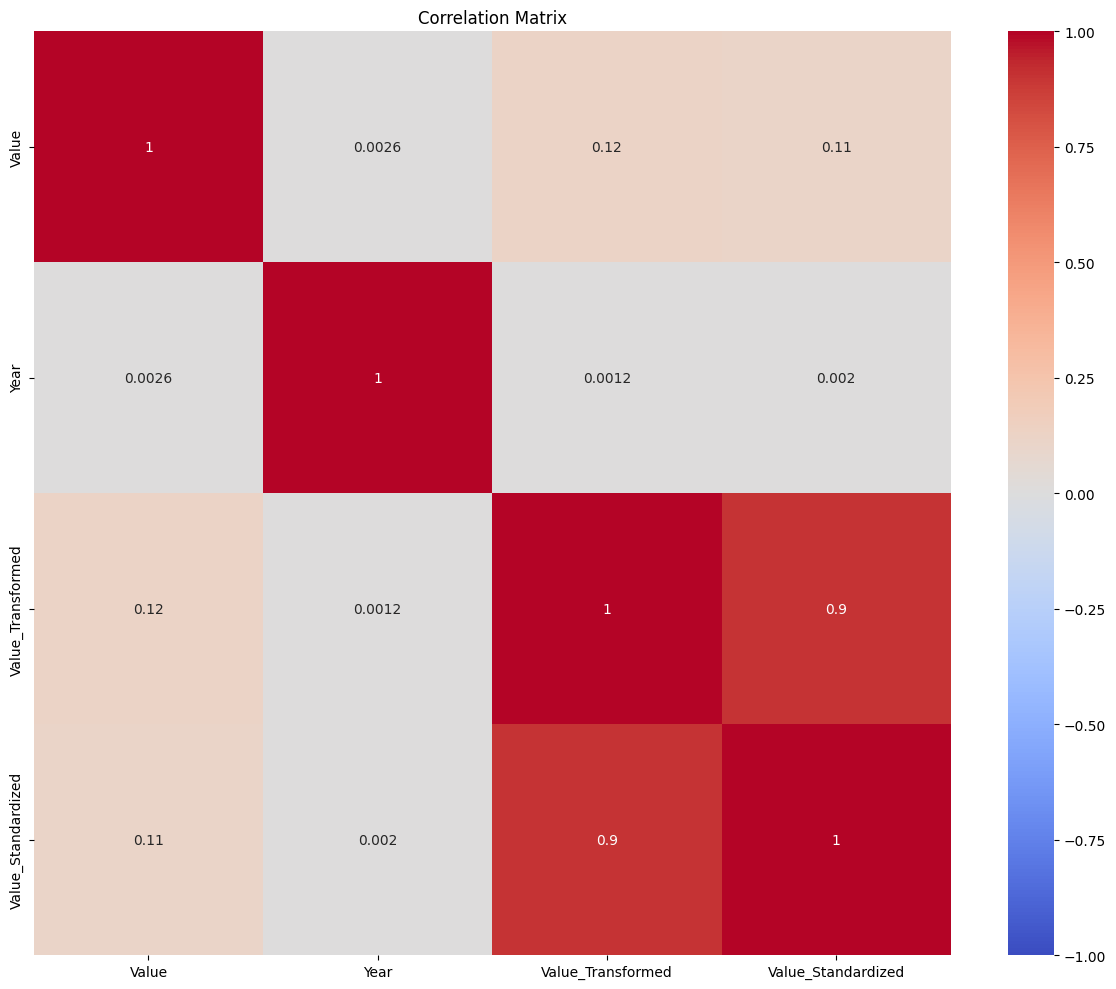

High correlations (>0.7):
                    Value  Year  Value_Transformed  Value_Standardized
Value                 NaN   NaN                NaN                 NaN
Year                  NaN   NaN                NaN                 NaN
Value_Transformed     NaN   NaN                NaN            0.900921
Value_Standardized    NaN   NaN                NaN                 NaN


In [ ]:
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Check for high correlations x > 0.7
high_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
print("High correlations (>0.7):")
print(high_corr[(high_corr > 0.7) | (high_corr < -0.7)])

In [ ]:
df = pd.read_csv('/content/Transformed_Imputed_and_cleaned_data_with_region.csv')
unique_series = df['Series Name'].unique()
unique_series_df = pd.DataFrame({'Series Name': unique_series})
print(unique_series_df.head())
unique_series_df.to_csv('/content/unique_series_list.csv', index=False)
print("\nSaved unique series names to '/content/unique_series_list.csv'")

                                         Series Name
0  Gross PSD, Budgetary Central Gov., All maturit...
1  Gross PSD, Budgetary Central Gov., All maturit...
2  Gross PSD, Budgetary Central Gov., All maturit...
3  Gross PSD, Budgetary Central Gov., All maturit...
4  Gross PSD, Budgetary Central Gov., All maturit...

Saved unique series names to '/content/unique_series_list.csv'
